<a href="https://colab.research.google.com/github/joanby/tensorflow2/blob/master/Collab%2012%20-%20Crear%20una%20API%20para%20Clasificar%20Imágenes%20con%20TensorFlow%20Serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Paso 1: Instalar las dependencias y configurar el proyecto en GPU


In [1]:
import sys

# Confirm that we're using Python 3
assert sys.version_info.major == 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

In [2]:
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [3]:
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb'
!dpkg -i tensorflow-model-server-universal_2.8.0_all.deb

--2022-11-02 17:19:14--  http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 172.217.194.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335421916 (320M) [application/x-debian-package]
Saving to: ‘tensorflow-model-server-universal_2.8.0_all.deb.1’

tensorflow-model-se 100%[===================>] 319.88M  15.6MB/s    in 23s     

2022-11-02 17:19:39 (14.2 MB/s) - ‘tensorflow-model-server-universal_2.8.0_all.deb.1’ saved [335421916/335421916]

(Reading database ... 123943 files and directories currently installed.)
Preparing to unpack tensorflow-model-server-universal_2.8.0_all.deb ...
Unpacking tensorflow-model-server-universal (2.8.0) over (2.8.0) ...
Setting u

In [29]:
# TensorFlow and tf.keras
print("Installing dependencies for Colab environment")
!pip install -Uq grpcio==1.26.0
!pip install -q requests

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import json
import requests

print('TensorFlow version: {}'.format(tf.__version__))

Installing dependencies for Colab environment
TensorFlow version: 2.9.2


## Paso 3: Pre procesado de los datos

### Cargar el dataset

In [7]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


In [8]:
class_names = ['avión', 'coche', 'pájaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión']

### Normalización de imágenes

In [9]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [10]:
X_train.shape

(50000, 32, 32, 3)

## Paso 4: Definir el modelo

NOTA: Vamos a usar el mismo modelo que creamos en la Sección de Redes Neuronales Convolucionales

In [11]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

### Compilar el modelo

In [12]:
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

###  Entrenar el modelo

In [13]:
model.fit(X_train, 
          y_train, 
          batch_size=128, 
          epochs=10)

Epoch 1/10
391/391 [==============================] - 11s 11ms/step - loss: 1.4796 - sparse_categorical_accuracy: 0.4700
Epoch 2/10
391/391 [==============================] - 4s 11ms/step - loss: 1.0344 - sparse_categorical_accuracy: 0.6349
Epoch 3/10
391/391 [==============================] - 4s 10ms/step - loss: 0.8447 - sparse_categorical_accuracy: 0.7064
Epoch 4/10
391/391 [==============================] - 4s 10ms/step - loss: 0.7277 - sparse_categorical_accuracy: 0.7464
Epoch 5/10
391/391 [==============================] - 4s 10ms/step - loss: 0.6291 - sparse_categorical_accuracy: 0.7811
Epoch 6/10
391/391 [==============================] - 4s 10ms/step - loss: 0.5462 - sparse_categorical_accuracy: 0.8082
Epoch 7/10
391/391 [==============================] - 4s 11ms/step - loss: 0.4741 - sparse_categorical_accuracy: 0.8336
Epoch 8/10
391/391 [==============================] - 4s 11ms/step - loss: 0.3964 - sparse_categorical_accuracy: 0.8630
Epoch 9/10
391/391 [===================

### Evaluar el modelo

In [14]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 0.9258 - sparse_categorical_accuracy: 0.7448


In [15]:
print("La precisión del modelo es de {} %".format(test_accuracy*100.0))

La precisión del modelo es de 74.47999715805054 %


## Paso 5: Guardar el modelo para subir a producción

### Crear un directorio para el modelo

In [16]:
MODEL_DIR = "model/"
version = 1

In [17]:
export_path = os.path.join(MODEL_DIR, str(version))
export_path

'model/1'

In [18]:
if os.path.isdir(export_path):
    !rm -r {export_path}

### Guardar el modelo para TensorFlow Serving

In [19]:
#tf.saved_model.simple_save(tf.keras.backend.get_session(), export_dir=export_path, inputs={"input_image":model.input}, outputs={t.name:t for t in model.outputs})
#tf.saved_model.save(model, export_path )
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = model/1




Saved model:
total 204
drwxr-xr-x 2 root root   4096 Nov  2 17:24 assets
-rw-r--r-- 1 root root  20532 Nov  2 17:24 keras_metadata.pb
-rw-r--r-- 1 root root 174440 Nov  2 17:24 saved_model.pb
drwxr-xr-x 2 root root   4096 Nov  2 17:24 variables


## Paso 6: Configurar el entorno de producción

### Exportar el MODEL_DIR a las variables de entorno

In [20]:
os.environ['MODEL_DIR'] = os.path.abspath(MODEL_DIR)

### Ejecutar la API REST de TensorFlow Serving

In [21]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8000 \
  --model_name=cifar10 \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [22]:
!tail server.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


## Paso 7: Crear nuestra primera petición por POST

In [46]:
random_image = np.random.randint(0, len(X_test))
random_image

5680

### Crear el objeto de datos en JSON

In [47]:
data = json.dumps({"signature_name":"serving_default", "instances":[X_test[random_image].tolist()]})

In [48]:
data

'{"signature_name": "serving_default", "instances": [[[[0.43529411764705883, 0.5058823529411764, 0.3607843137254902], [0.4666666666666667, 0.5490196078431373, 0.37254901960784315], [0.43529411764705883, 0.5254901960784314, 0.3411764705882353], [0.4235294117647059, 0.5176470588235295, 0.35294117647058826], [0.40784313725490196, 0.49411764705882355, 0.35294117647058826], [0.41568627450980394, 0.49411764705882355, 0.3568627450980392], [0.42745098039215684, 0.5098039215686274, 0.34509803921568627], [0.4196078431372549, 0.4980392156862745, 0.3176470588235294], [0.5058823529411764, 0.5764705882352941, 0.4117647058823529], [0.5372549019607843, 0.6039215686274509, 0.4549019607843137], [0.5372549019607843, 0.596078431372549, 0.4470588235294118], [0.4666666666666667, 0.5411764705882353, 0.4], [0.403921568627451, 0.4980392156862745, 0.3843137254901961], [0.4235294117647059, 0.5098039215686274, 0.43137254901960786], [0.44313725490196076, 0.5098039215686274, 0.4588235294117647], [0.4431372549019607

### Enviar la primera petición POST al modelo

In [49]:
headers = {"content-type":"application/json"}

In [50]:
json_response = requests.post(url="http://localhost:8000/v1/models/cifar10:predict", data=data, headers=headers)

In [51]:
json_response

<Response [200]>

In [52]:
predictions = json.loads(json_response.text)['predictions']

In [53]:
predictions

[[6.28439739e-05,
  0.136959955,
  0.71332413,
  0.0505175814,
  0.00213742885,
  0.0853558704,
  7.75774606e-05,
  0.0115404762,
  1.47949413e-06,
  2.27507699e-05]]

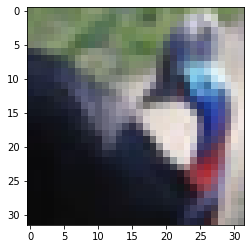

In [54]:
plt.imshow(X_test[random_image])

In [55]:
class_names[np.argmax(predictions[0])]

'pájaro'

## Paso 8: Enviar una petición POST a un modelo específico 

In [56]:
specific_json_response = requests.post(url="http://localhost:8000/v1/models/cifar10/versions/1:predict", data=data, headers=headers)

In [57]:
specific_json_response

<Response [200]>